In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read in the data
df=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/rotten-tomatoes-analysis/main/data/rotten_tomatoes_movies.csv")
print(df.shape)

(17712, 22)


In [2]:
del df['rotten_tomatoes_link'], df['tomatometer_top_critics_count'], df['tomatometer_fresh_critics_count'], df['tomatometer_rotten_critics_count']

In [3]:
#Create new features
df[['og_year','og_month','og_day']] = df['original_release_date'].str.split('-',expand=True)
df[['str_year','str_month','str_day']] = df['streaming_release_date'].str.split('-',expand=True)
df['num_actors'] = df['actors'].str.count(',')+1
df['num_actors_group'] = pd.cut(df['num_actors'],
                      bins=[0, 5, 10, 25, 100, float('Inf')],
                      labels=['0-10', '10-25', '25-50','50-100','100+'])

In [4]:
df = df[(df['og_year'].notna()) & (df['str_year'].notna())]
df.shape

(16305, 26)

In [5]:
#Convert time features to integers
df['og_year'] = df['og_year'].astype(int)
df['str_year'] = df['str_year'].astype(int)

df['og_month'] = df['og_month'].astype(int)
df['str_month'] = df['str_month'].astype(int)

df['og_day'] = df['og_day'].astype(int)
df['str_day'] = df['str_day'].astype(int)

In [6]:
from nltk.tokenize import RegexpTokenizer
#!pip install contractions
import contractions
import re

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def lemmatize(text):
    lemmed = contractions.fix(str(text))
    return lemmed


In [7]:
#Apply standardizing functions to body of email column
from nltk.corpus import stopwords

stop = stopwords.words('english')

#0.) Convert everything to string
df['cleaned_movie_info'] = df['movie_info'].astype(str)
df['cleaned_critics_consensus'] = df['critics_consensus'].astype(str)

#1.) Lowercase
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].str.lower()
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].str.lower()

#2.) Remove punctuation
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = punct)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = punct)

#3.) Remove non alpha-numeric characters
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_special_characters)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_special_characters)

#4.) Remove digits
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_digits)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_digits)

#5.) Lemmatize words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = lemmatize)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = lemmatize)

#6. Remove stop words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))



In [8]:
#Set up VADER score to get labels for doing classification later
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['synposis_scores_unpack'] = df['cleaned_movie_info'].map(lambda x: sia.polarity_scores(x))
df['critic_scores_unpack'] = df['cleaned_critics_consensus'].map(lambda x: sia.polarity_scores(x))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonzimmerman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
df['synopsis_sentiment_score']  = df['synposis_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['synopsis_sentiment_class'] = df['synopsis_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df['critic_sentiment_score']  = df['critic_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['critic_sentiment_class'] = df['critic_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df.head(2)

,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,...,num_actors,num_actors_group,cleaned_movie_info,cleaned_critics_consensus,synposis_scores_unpack,critic_scores_unpack,synopsis_sentiment_score,synopsis_sentiment_class,critic_sentiment_score,critic_sentiment_class
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,...,87.0,50-100,always trouble prone life teenager percy jacks...,though may seem like another harry potter knoc...,"{'neg': 0.215, 'neu': 0.55, 'pos': 0.235, 'com...","{'neg': 0.0, 'neu': 0.507, 'pos': 0.493, 'comp...",-0.2023,0,0.9274,1
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2012-09-04,...,8.0,10-25,kate catherine keener husband alex oliver plat...,nicole holofcener newest might seem slight pla...,"{'neg': 0.089, 'neu': 0.789, 'pos': 0.121, 'co...","{'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...",0.2023,1,0.3612,1


## Set up the cluster analysis

In [10]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.impute import KNNImputer
import warnings
#!pip install kneed
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [11]:
df.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'content_rating',
       'genres', 'directors', 'authors', 'actors', 'original_release_date',
       'streaming_release_date', 'runtime', 'production_company',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count', 'og_year',
       'og_month', 'og_day', 'str_year', 'str_month', 'str_day', 'num_actors',
       'num_actors_group', 'cleaned_movie_info', 'cleaned_critics_consensus',
       'synposis_scores_unpack', 'critic_scores_unpack',
       'synopsis_sentiment_score', 'synopsis_sentiment_class',
       'critic_sentiment_score', 'critic_sentiment_class'],
      dtype='object')

In [12]:
df.shape

(16305, 34)

In [63]:
genre_df = pd.DataFrame(df['genres'].value_counts().head(15)).reset_index()
genre_list = genre_df['index'].values.tolist()


df['genre_squeeze'] = np.where(df['genres'].isin(genre_list),df['genres'],'Other')
df['genre_squeeze'].value_counts()

Other                                            7988
Drama                                            1735
Comedy                                           1132
Comedy, Drama                                     825
Drama, Mystery & Suspense                         682
Art House & International, Drama                  552
Documentary, Special Interest                     516
Documentary                                       408
Horror                                            390
Action & Adventure, Drama                         345
Action & Adventure, Drama, Mystery & Suspense     321
Horror, Mystery & Suspense                        309
Comedy, Drama, Romance                            301
Drama, Romance                                    294
Comedy, Romance                                   255
Art House & International, Comedy, Drama          252
Name: genre_squeeze, dtype: int64

In [70]:
#one_hot = pd.get_dummies(df['genre_squeeze'])
#df = df.drop('genre_squeeze',axis = 1)
#df = df.join(one_hot)
df.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'content_rating',
       'genres', 'directors', 'authors', 'actors', 'original_release_date',
       'streaming_release_date', 'runtime', 'production_company',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count', 'og_year',
       'og_month', 'og_day', 'str_year', 'str_month', 'str_day', 'num_actors',
       'num_actors_group', 'cleaned_movie_info', 'cleaned_critics_consensus',
       'synposis_scores_unpack', 'critic_scores_unpack',
       'synopsis_sentiment_score', 'synopsis_sentiment_class',
       'critic_sentiment_score', 'critic_sentiment_class',
       'Action & Adventure, Drama',
       'Action & Adventure, Drama, Mystery & Suspense',
       'Art House & International, Comedy, Drama',
       'Art House & International, Drama', 'Comedy', 'Comedy, Drama',
       'Comedy, Drama, Romance', 'Comedy, Romance', 'Documentary',
       'Documentary, 

In [85]:
#Step 0: Create df with name and synopsis
pre_cluster_df = df[['movie_title','movie_info','tomatometer_rating','audience_rating','og_year','synopsis_sentiment_score','critic_sentiment_score','Action & Adventure, Drama',
       'Action & Adventure, Drama, Mystery & Suspense',
       'Art House & International, Comedy, Drama',
       'Art House & International, Drama', 'Comedy', 'Comedy, Drama',
       'Comedy, Drama, Romance', 'Comedy, Romance', 'Documentary',
       'Documentary, Special Interest', 'Drama', 'Drama, Mystery & Suspense',
       'Drama, Romance', 'Horror', 'Horror, Mystery & Suspense']]
pre_cluster_df = pre_cluster_df.dropna()
pre_cluster_df.shape

(16137, 22)

In [86]:
#Step 1: Prepare data
X = pre_cluster_df.loc[:, ~pre_cluster_df.columns.isin(['movie_title', 'movie_info'])]
X = X.dropna()
X.shape

(16137, 20)

In [87]:
#Step 2: Standardizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

In [88]:
#Step 3: Defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++')

In [89]:
#Step 4: Fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

KMeans(n_clusters=2)

In [90]:
#Step 5: Fitting multiple k-means algorithms and storing the values in an empty list
warnings.filterwarnings('ignore')

SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)
    
#Range in KneeLocator must be the same as range above    
kl = KneeLocator(
    range(1, 20), SSE, curve="convex", direction="decreasing"
)

elbow = kl.elbow
elbow

15

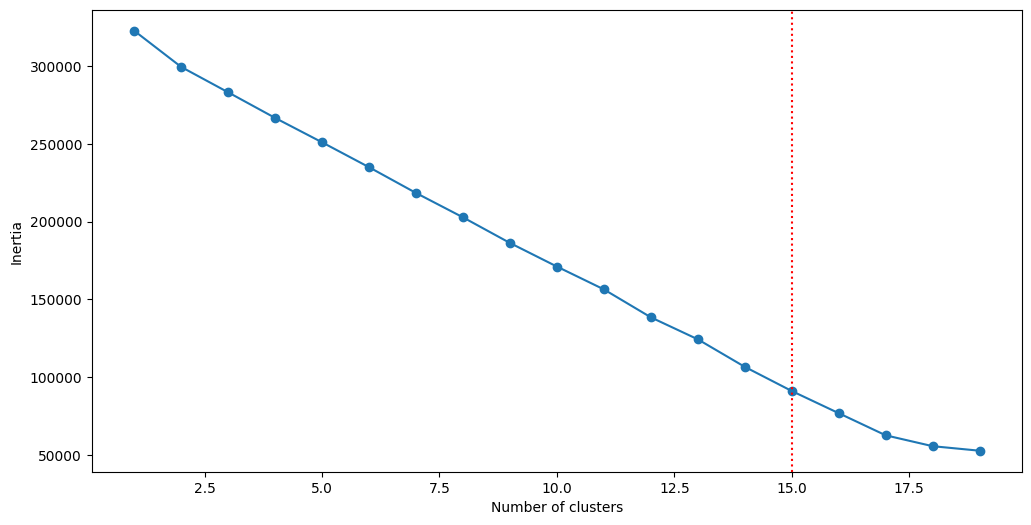

In [91]:
#Step 6: Converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.axvline(x=elbow,ls=':',color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

In [96]:
#Step 7: k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = elbow, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

In [97]:
#Step 8: Place the clusters back in original df
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

clusters = frame['cluster']+1

pre_cluster_df['cluster'] = clusters.values

pre_cluster_df.head(3)

,movie_title,movie_info,tomatometer_rating,audience_rating,og_year,synopsis_sentiment_score,critic_sentiment_score,"Action & Adventure, Drama","Action & Adventure, Drama, Mystery & Suspense","Art House & International, Comedy, Drama",...,"Comedy, Drama, Romance","Comedy, Romance",Documentary,"Documentary, Special Interest",Drama,"Drama, Mystery & Suspense","Drama, Romance",Horror,"Horror, Mystery & Suspense",cluster
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",49.0,53.0,2010,-0.2023,0.9274,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,87.0,64.0,2010,0.2023,0.3612,0,0,0,...,0,0,0,0,0,0,0,0,0,15
2,10,"A successful, middle-aged Hollywood songwriter...",67.0,53.0,1979,0.8442,0.6124,0,0,0,...,0,1,0,0,0,0,0,0,0,6


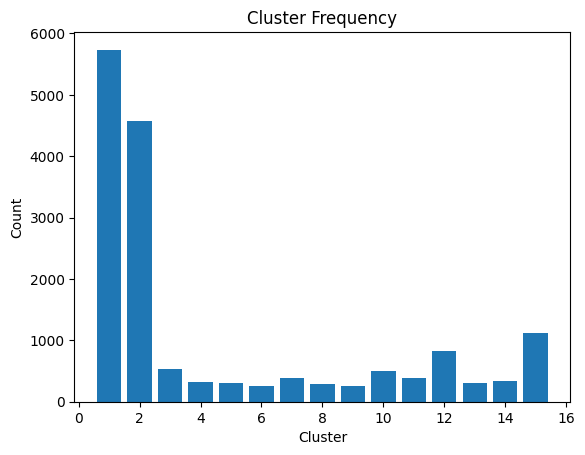

In [98]:
#Rating count
bar_df = pd.DataFrame(pre_cluster_df['cluster'].value_counts()).reset_index()
    
bar_df = bar_df.rename(columns={
        bar_df.columns[0]: "cluster" ,
        bar_df.columns[1]: "count" 
    })

plt.bar(bar_df['cluster'],bar_df['count'])
plt.title('Cluster Frequency')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [99]:
#List movies with top ten critic scores by cluster
post_cluster_df = pre_cluster_df
post_cluster_df.head(2)

,movie_title,movie_info,tomatometer_rating,audience_rating,og_year,synopsis_sentiment_score,critic_sentiment_score,"Action & Adventure, Drama","Action & Adventure, Drama, Mystery & Suspense","Art House & International, Comedy, Drama",...,"Comedy, Drama, Romance","Comedy, Romance",Documentary,"Documentary, Special Interest",Drama,"Drama, Mystery & Suspense","Drama, Romance",Horror,"Horror, Mystery & Suspense",cluster
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",49.0,53.0,2010,-0.2023,0.9274,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,87.0,64.0,2010,0.2023,0.3612,0,0,0,...,0,0,0,0,0,0,0,0,0,15


In [100]:
def browse_recommendations(df_to_use,var_to_sort,num_of_movies,cluster_num):

    post_cluster_df = df_to_use.sort_values(by=['cluster',f'{var_to_sort}'],ascending=False)
    post_cluster_df = post_cluster_df.groupby('cluster').head(num_of_movies).reset_index(drop=True)
    post_cluster_df = post_cluster_df[post_cluster_df['cluster']==cluster_num]
    return post_cluster_df[['movie_title','movie_info',f'{var_to_sort}']]

In [121]:
browse_recommendations(post_cluster_df,'tomatometer_rating',10,13)

,movie_title,movie_info,tomatometer_rating
20,Creep 2,A video artist quickly realizes she has made a...,100.0
21,The Gravedancers,"After a funeral, several college friends reuni...",100.0
22,Last Shift,A rookie cop's first solo shift in a closing s...,100.0
23,Get Out,Now that Chris (Daniel Kaluuya) and his girlfr...,98.0
24,Halloween,"On a cold Halloween night in 1963, six year ol...",96.0
25,The Silence of the Lambs,"Jodie Foster stars as Clarice Starling, a top ...",96.0
26,Lake Mungo,Alice drowns while swimming and her family beg...,95.0
27,A Nightmare on Elm Street,"In Wes Craven's classic slasher film, several ...",94.0
28,CAM,"A camgirl has her principles, until a mysterio...",93.0
29,Us,"Accompanied by her husband, son and daughter, ...",93.0
